# 2. EDA

This section regards the Explanatory Data Analysis, which consists in different parts:
- basic EDA on features
- insights on reviews and time periods
- sentiment - review relationship
- WordClouds
- N-gram analysis

In [43]:
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import json
import re
from textblob import TextBlob
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk import FreqDist
from nltk.util import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer

In [44]:
pd.set_option("max_colwidth", None)
plt.style.use('ggplot')

In [45]:
df = pd.read_csv('G:/Il mio Drive/MAGISTRALE/IT Coding/Project/Sentiment-Analysis-on-Amazon-product-reviews/Data/clean_reviews.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head(3)

,Clean Review,Review,Title,Content,Rating,Sentiment,Year,Month,Day
0,good sound seem decent build quality good sound happy purchase,good sound. seem decent build quality and good sound. very happy with purchase.,good sound,seem decent build quality and good sound. very happy with purchase.,5,Positive,2023,5,28
1,not realise bad audio setup considering used quite respectable setup many years ago feel trap using bluetooth speakers leave lot desired price provide perfect audio experience filling 3x3m room hardly auditorium quality amazing feel like subwoofer genres average listening experience without neighbours complaining beautiful almost brings tear eye,"i didn't realise how bad my audio setup was. considering i used to have quite a respectable setup many years ago i've feel into a trap of using bluetooth speakers which leave a lot to be desired. for the price these provide a perfect audio experience. now i'm only filling a 3x3m room so hardly an auditorium but the quality is amazing. i do feel like i could do with a subwoofer for some genres but for the average listening experience, without the neighbours complaining, it's beautiful. almost brings a tear to my eye.",i didn't realise how bad my audio setup was,"considering i used to have quite a respectable setup many years ago i've feel into a trap of using bluetooth speakers which leave a lot to be desired. for the price these provide a perfect audio experience. now i'm only filling a 3x3m room so hardly an auditorium but the quality is amazing. i do feel like i could do with a subwoofer for some genres but for the average listening experience, without the neighbours complaining, it's beautiful. almost brings a tear to my eye.",5,Positive,2023,5,27
2,beauty love compact shape sound,its a beauty. love its compact shape and sound,its a beauty,love its compact shape and sound,5,Positive,2023,5,26


- Review: title + content to maintain context and syntax
- Clean review: it is the Review column without emoticons, punctuation, special characters and most importantly without stopwords

## Exploratory Data Analysis

### Basic and quick EDA on some features

In [46]:
# column types
df.dtypes

Clean Review    object
Review          object
Title           object
Content         object
Rating           int64
Sentiment       object
Year             int64
Month            int64
Day              int64
dtype: object

In [47]:
# NA check
df.isna().sum()

Clean Review    0
Review          0
Title           0
Content         9
Rating          0
Sentiment       0
Year            0
Month           0
Day             0
dtype: int64

Looks like that with the .to_csv() conversion the empty contents are now Missing values. This does not bother me since my interested columns are Reviews and Clean Reviews, replacing the missing values with simply the title.

In [48]:
df[df['Content'].isna()]

,Clean Review,Review,Title,Content,Rating,Sentiment,Year,Month,Day
12,great deal,great deal..,great deal.,NaN,5,Positive,2023,5,7
53,impressive,impressive.,impressive,NaN,5,Positive,2023,3,4
78,loud clear audio,"loud, and very clear audio.","loud, and very clear audio",NaN,5,Positive,2022,12,29
167,awesome general balanced sound,awesome! general balanced sound!.,awesome! general balanced sound!,NaN,5,Positive,2022,6,24
291,great job presonus,great job presonus.,great job presonus,NaN,5,Positive,2021,10,29
296,amazing,amazing.,amazing,NaN,5,Positive,2021,10,17
387,best speakers ever owned,the best speakers i have ever owned.,the best speakers i have ever owned,NaN,5,Positive,2021,4,12
563,amazing sound best ever heard,amazing sound. best i have ever heard.,amazing sound. best i have ever heard,NaN,5,Positive,2020,5,7
601,good quality,good quality.,good quality,NaN,3,Neutral,2020,2,14


Looks like for the rest we have 0 missing values.

In [49]:
for col in df.columns:
    display(pd.DataFrame(df[col].describe()))
    print("\n")

,Clean Review
count,740
unique,739
top,excellent excellent
freq,2


,Review
count,740
unique,739
top,excellent. excellent
freq,2


,Title
count,740
unique,653
top,five stars
freq,9


,Content
count,731
unique,728
top,great product
freq,3


,Rating
count,740.000000
mean,4.481081
std,1.100335
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


,Sentiment
count,740
unique,3
top,Positive
freq,643


,Year
count,740.000000
mean,2020.718919
std,1.680717
min,2014.000000
25%,2020.000000
50%,2021.000000
75%,2022.000000
max,2023.000000


,Month
count,740.000000
mean,6.325676
std,3.560517
min,1.000000
25%,3.000000
50%,6.000000
75%,10.000000
max,12.000000


,Day
count,740.000000
mean,15.406757
std,8.798032
min,1.000000
25%,8.000000
50%,15.000000
75%,23.000000
max,31.000000


On a total of 740 reviews, We have 653 unique titles and 728 unique review contents. The value **top** and **freq** in the categorical features describe() dataframes indicate the most frequent value and its frequency. Basically **'five Stars'** appears 9 times in the Title column.

In [50]:
# checking relative frequencies for each sentiment
df['Sentiment'].value_counts()/df.shape[0]

Positive    0.868919
Negative    0.089189
Neutral     0.041892
Name: Sentiment, dtype: float64

### Insights on reviews and time periods

In these next graphs I will present the number of reviews along with their sentiment for each year, month and day. To make these histograms i grouped the review counts by year, month and day to then plot each value.

I assume that there will be no correlation between the time period and the sentiment, therefore the most impactful plots will be the first 3.

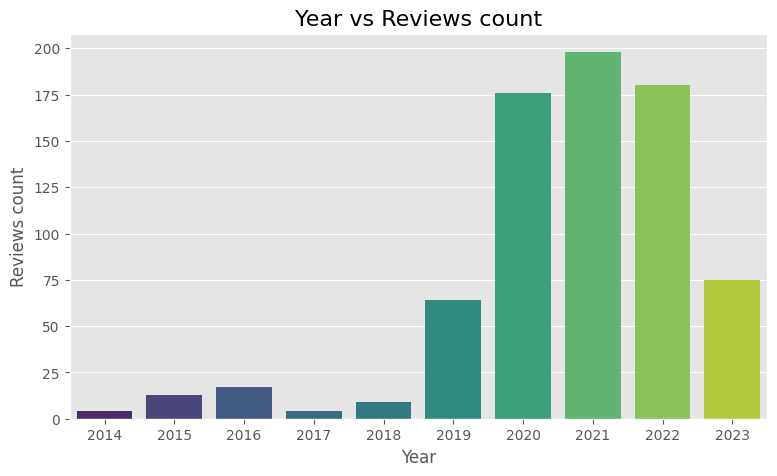

In [51]:
plt.figure(figsize=(9, 5))

year = pd.DataFrame(df.groupby('Year')['Review'].count()).reset_index()
year['Year'] = year['Year'].astype('int64')
year.sort_values(by=['Year'])

sns.barplot(x="Year", y="Review", data=year, palette='viridis', estimator=sum)      #sum for counting
plt.title('Year vs Reviews count', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Reviews count', fontsize=12)
plt.show()

From this barplot we deduct that the boom of the product has been between 2019 and 2020, even if there were some reviews from 2014 onwards. Obviously the 2023 reviews are much less than the other recent years.

Also, as a home product, the speakers saw an exponential increase in sales maybe due to the COVID-19 pandemic, and this led also to more reviews.

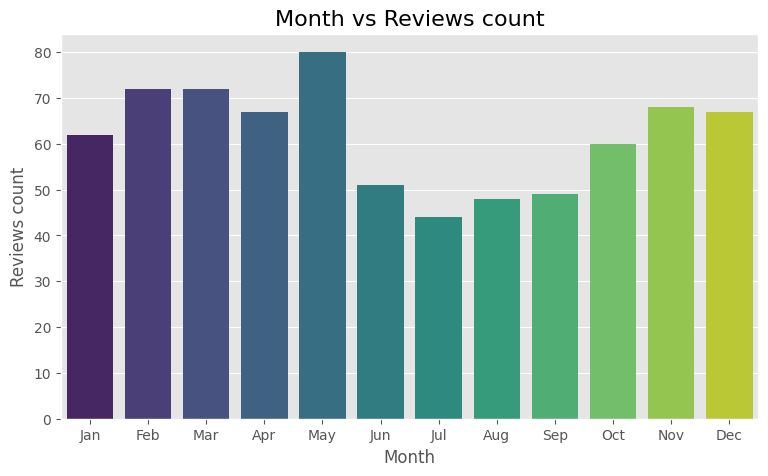

In [52]:
plt.figure(figsize=(9, 5))

month = pd.DataFrame(df.groupby('Month')['Review'].count()).reset_index()
month['Month'] = month['Month'].astype('int64')
month.sort_values(by=['Month'])
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

sns.barplot(x="Month", y="Review", data=month, palette='viridis')
plt.title('Month vs Reviews count', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Reviews count', fontsize=12)
plt.xticks(range(len(month_labels)), month_labels)      # to put the labels
plt.show()

Looks like there tends to be less reviews during summer time!

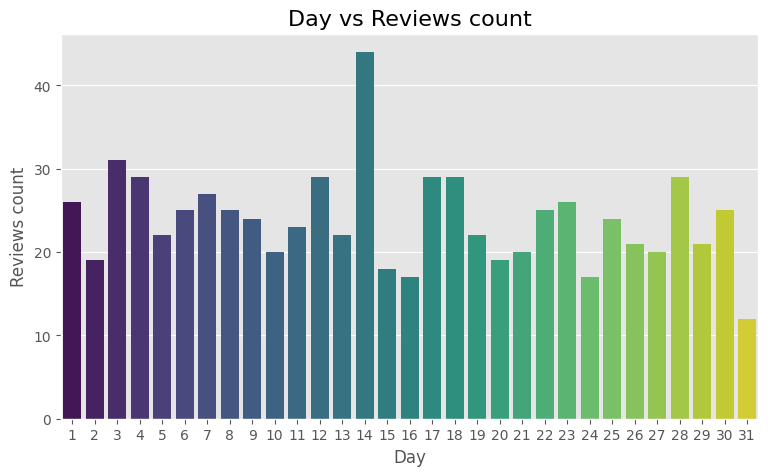

In [53]:
plt.figure(figsize=(9, 5))
day = pd.DataFrame(df.groupby('Day')['Review'].count()).reset_index()

sns.barplot(x="Day", y="Review", data=day, palette='viridis')
plt.title('Day vs Reviews count', fontsize=16)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Reviews count', fontsize=12)
plt.show()

The review counts are more or less uniformly distributed, unless from the day 14 of the month. There isn't that much variance between the days. But there is a for sure a little drop at the end of month.

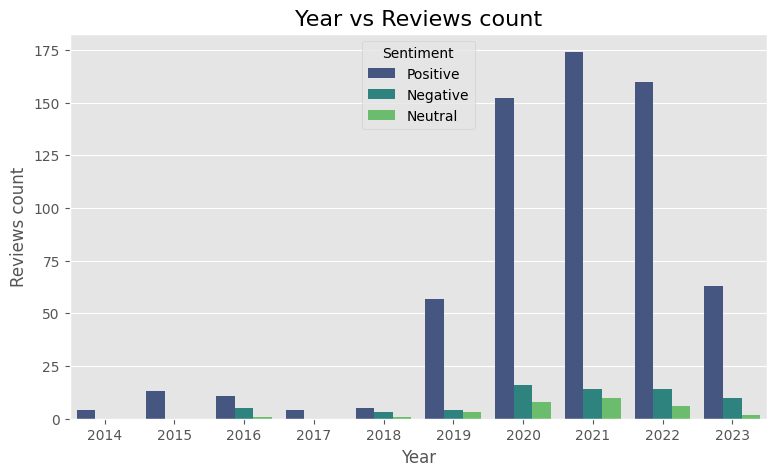

In [54]:
plt.figure(figsize=(9, 5))
Year = pd.DataFrame(df.groupby(['Year', 'Sentiment'])['Review'].count()).reset_index()

sns.barplot(x="Year", y="Review", hue='Sentiment', data=Year, palette='viridis')
plt.title('Year vs Reviews count', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Reviews count', fontsize=12)
plt.show()

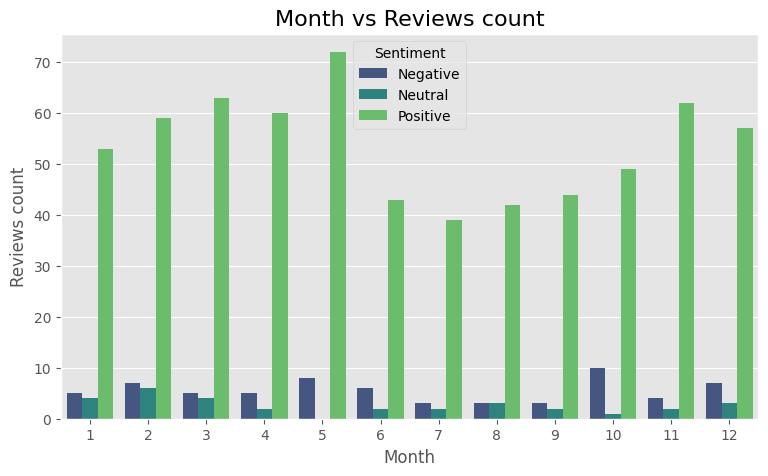

In [55]:
plt.figure(figsize=(9, 5))
Month = pd.DataFrame(df.groupby(['Month', 'Sentiment'])['Review'].count()).reset_index()

sns.barplot(x="Month", y="Review", hue='Sentiment', data=Month, palette='viridis')
plt.title('Month vs Reviews count', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Reviews count', fontsize=12)
plt.show()

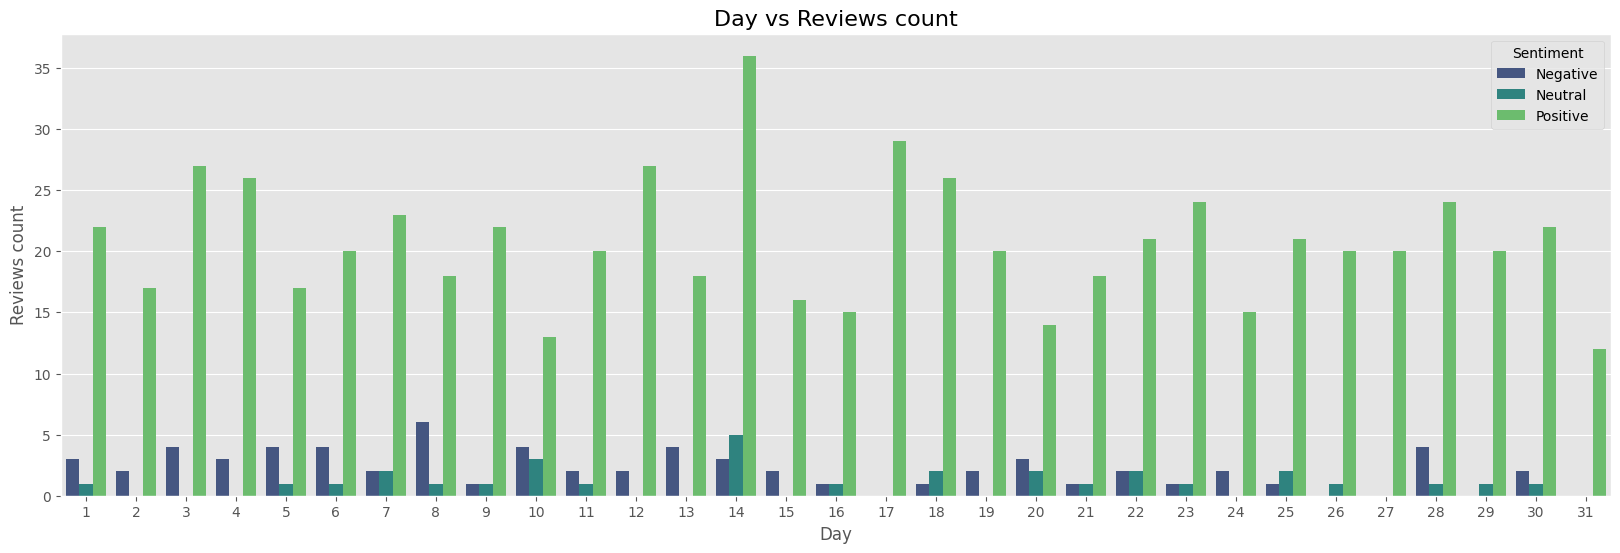

In [56]:
plt.figure(figsize=(20, 6))
day = pd.DataFrame(df.groupby(['Day', 'Sentiment'])['Review'].count()).reset_index()

sns.barplot(x="Day", y="Review", hue='Sentiment', data=day, palette='viridis')
plt.title('Day vs Reviews count', fontsize=16)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Reviews count', fontsize=12)
plt.show()

These plots confirm my initial assumption, showing that there is absolutely no correlation between the review's sentiment and the time in which the user writes the feedback.

### Sentiment - Review Relationship

I assume to find longer reviews for higher polarities: it means that a higly satisfied customer is more incline of writing a long and positive review, and the same thing for a customer which is highly unsatistifed with the product. This section is important since I will also add some more features.

Let's see if my assumption is right.

Let's also investigate for which positive reviews the polarity is negative and viceversa (most likely ironic reviews).

N.B: in the beginning I used Textblob to do the ploarity analysis, but then I found out that VADER outperforms TB by over 20% (TextBlob was struggling with negative sentences, particularly negations). Therefore, I will proceed the polarity analysis with VADER and not with TB. (Source: https://www.analyticsvidhya.com/blog/2021/10/sentiment-analysis-with-textblob-and-vader/#:~:text=In%20the%20above%2Dmentioned%20confusion,gets%20an%20accuracy%20of%2041.3%25.)

This type of result is exactly what we want after building the models.

#### VADER

Valence Aware Dictionary and Sentiment Reasoner a.k.a. VADER is another Lexicon-based sentiment analyzer that has pre-defined rules for words or lexicons. VADER not only tells the lexicon is positive, negative, or neutral, it also tells how positive, negative, or neutral a sentence is. VADER's compound score, which is an aggregation of the 3 sentiments, goes from -1 to 1 (negative to positive), is much better than the TextBlob polarities.

In [57]:
sia = SentimentIntensityAnalyzer()          # creating the analyzer object
# run the analyzer on entire matrix
results = {}
for i, row in df.iterrows():
    text = row['Review']
    Id = i
    results[Id] = sia.polarity_scores(text)

In [58]:
# create a new dataframe
# will integrate later the vader's polarities in the OG dataset
vaders = pd.DataFrame(results).T        # transpose to have the rows indexes as columns
vaders = vaders.reset_index().rename(columns={'index': 'Id',
                                              'neg': 'Vaders neg',
                                              'neu': 'Vaders neu',
                                              'pos': 'Vaders pos',
                                              'compound': 'Vaders compound'})

df['Id'] = range(df.shape[0])
vaders = vaders.merge(df, how='left')
vaders.head(1)

,Id,Vaders neg,Vaders neu,Vaders pos,Vaders compound,Clean Review,Review,Title,Content,Rating,Sentiment,Year,Month,Day
0,0,0.0,0.505,0.495,0.8687,good sound seem decent build quality good sound happy purchase,good sound. seem decent build quality and good sound. very happy with purchase.,good sound,seem decent build quality and good sound. very happy with purchase.,5,Positive,2023,5,28


Is this in line with what we expect? If the rating is 5-4, is the rating positive? Let's check for integrity purposes.

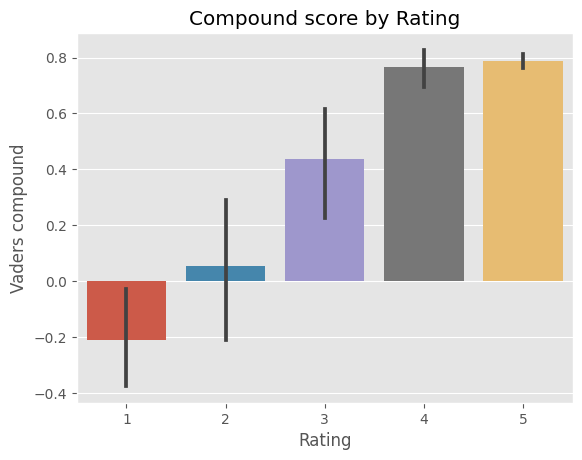

In [59]:
ax = sns.barplot(data=vaders, x='Rating', y='Vaders compound')
ax.set_title('Compound score by Rating')
plt.show()

It is what we would expect. Awesome.

Pltting also the sentiments for completeness.

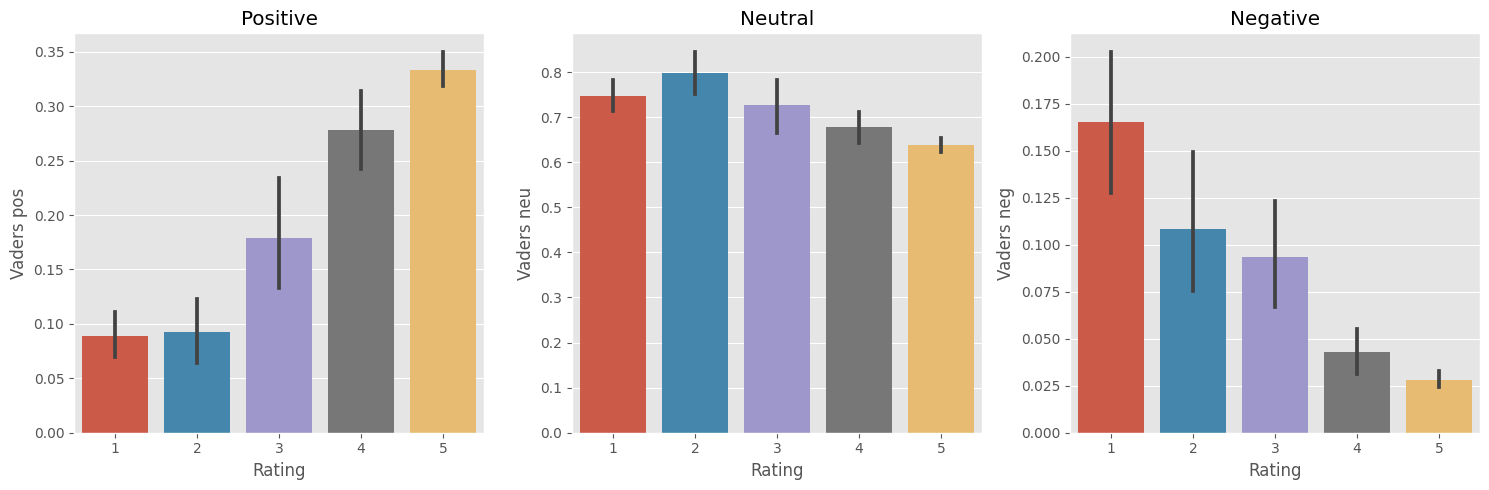

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data = vaders, x='Rating', y='Vaders pos', ax = axs[0])
sns.barplot(data = vaders, x='Rating', y='Vaders neu', ax = axs[1])
sns.barplot(data = vaders, x='Rating', y='Vaders neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

**New features:**
- Polarity: Using VADER for figuring out the rate of sentiment. It is between [-1,1] where -1 is negative and 1 is positive polarity
- Review length: length of the review, which includes each letters and spaces
- Word length: how many words are there in every review (including emoticons and punctuation)

In [61]:
# TB = TextBlob Polarity
# df[' TB Polarity'] = df['Review'].map(lambda text: TextBlob(text).sentiment.polarity)
df['Review Length'] = df['Review'].astype(str).apply(len)
df['Word Count'] = df['Review'].apply(lambda x: len(str(x).split()))

In [62]:
results = {}
for i, row in df.iterrows():
    text = row['Review']
    Id = i
    polarity = sia.polarity_scores(text)['compound']
    results[Id] = polarity

df['Polarity'] = pd.Series(results)

In [63]:
df.head(1)

,Clean Review,Review,Title,Content,Rating,Sentiment,Year,Month,Day,Id,Review Length,Word Count,Polarity
0,good sound seem decent build quality good sound happy purchase,good sound. seem decent build quality and good sound. very happy with purchase.,good sound,seem decent build quality and good sound. very happy with purchase.,5,Positive,2023,5,28,0,79,13,0.8687


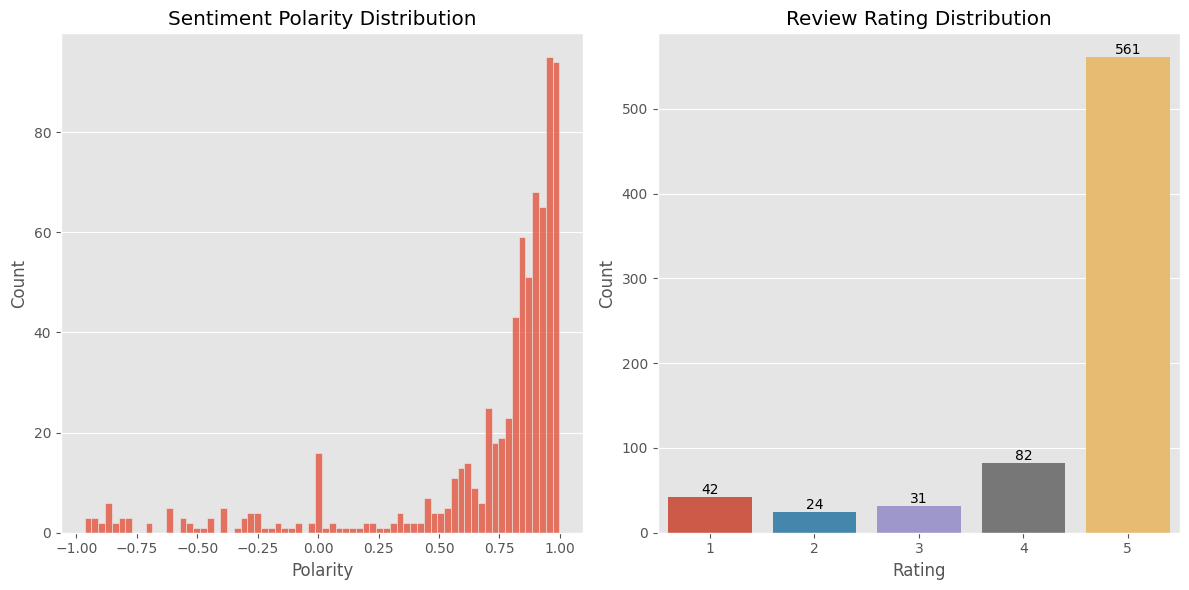

In [64]:
# Rating distribution along with Sentiment polarity (Textblob baseline)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Ratings
sns.countplot(x=df['Rating'], ax=axs[1])
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Count')
axs[1].set_title('Review Rating Distribution')
for i, count in enumerate(df['Rating'].value_counts().sort_index()):
    axs[1].annotate(count, (i, count), ha='center', va='bottom')

# Polarity
sns.histplot(df['Polarity'], bins=70, kde=False, ax=axs[0])
axs[0].set_xlabel('Polarity')
axs[0].set_ylabel('Count')
axs[0].set_title('Sentiment Polarity Distribution')
axs[0].grid(axis='x')

plt.tight_layout()
plt.show()

Very biased towards positive reviews.

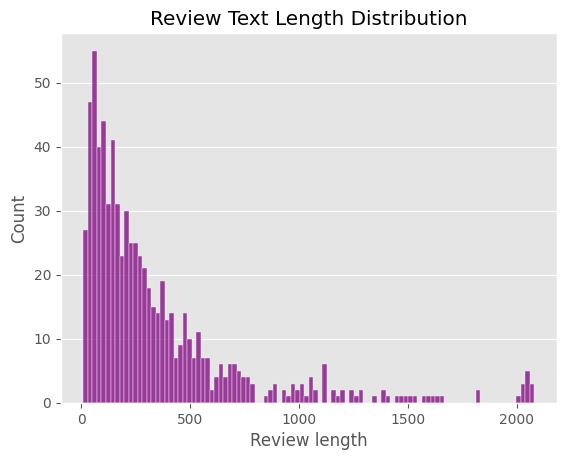

In [65]:
# Review Length Distribution
sns.histplot(df['Review Length'], bins=100, color="purple")
plt.xlabel('Review length')
plt.ylabel('Count')
plt.title('Review Text Length Distribution')
plt.grid(axis='x')
plt.show()

Highly positively skewed distribution where most of the lengths falls between 0-500.

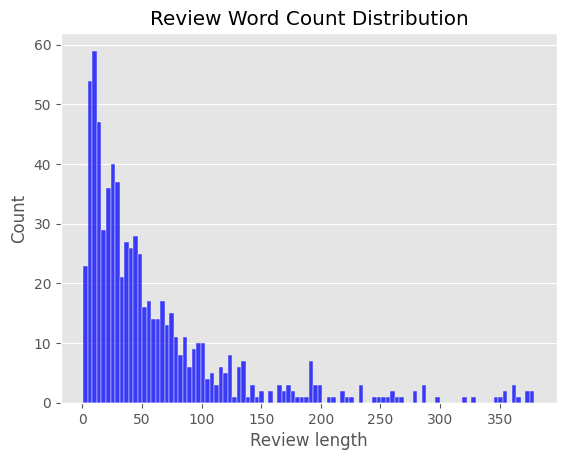

In [66]:
# Review word count Distribution
sns.histplot(df['Word Count'], bins=100, color="blue")
plt.xlabel('Review length')
plt.ylabel('Count')
plt.title('Review Word Count Distribution')
plt.grid(axis='x')
plt.show()

As previously, but most of the reviews are 0 to 50 words long.

Let's take a look now to the not-correctly classified reviews: the positive reviews with a negative TB polarity and viceversa.

In [67]:
# "ironic" reviews that could be difficult for TextBlob to interpret
df[(df['Polarity'] < 0) & (df['Rating'] >= 4)][['Review', 'Sentiment', 'Polarity', 'Review Length']]

,Review,Sentiment,Polarity,Review Length
22,wicked speakers. for the price and size i was blown away by the quality of sound on these. very loud and good bass with no distortion. highly recommended,Positive,-0.0883,153
40,"boom, boom. boom. neighbours hate it.",Positive,-0.5719,37
108,"proper. amazing for fun studio or daily music listening, on logic pro x the bass is a bit weird ngl but on professional mixes and masters this is insane",Positive,-0.0900,152
109,"excellent range. don’t forget to increase the lows at the back for those that like more bass (for those parties). im hearing more instruments and sounds than in my previous speakers. insane value for money - was contemplating the similar pioneers, but with bluetooth included and still being cheaper these are a no brainer",Positive,-0.0129,322
138,definitely adds oomph. was skeptical whether this would complement my eris e5s. but it definitely fills a gap in my bad acoustic home studio.,Positive,-0.2500,141
140,"vast improvement on cheap pc speakers. my logitech z506 5.1 pc sound system served me well for a decade but finally decided to stop working. as a temporary measure i set up the dell pc speakers that had come with the system, and was shocked at how bad they were were! i was about to buy the z607 speaker system, as being the nearest direct replacement to the z506, when i spotted a recommendation on the internet to try the presonus eris e3.5 instead. i was a bit dubious about ""downgrading"" to just stereo speakers, but i had long stopped using the rear speakers of the z506 as they didn't give true surround sound and locating them correctly and running the wires safely was always a problem. also, i rarely had the subwoofer turned up that rapidly gained complaints from the rest of the family! anyway, the eris speakers are very easy to setup, the sound is as good - if not better - than the old z506, and general setup is tidier, with no sub-woofer or centre speaker. if you are demanding music connoisseur or have a high-end gaming rig then look else where, but for the average home user looking for a simple solution that will provide decent but not exceptional sound at a relatively low price - definitely an option to consider seriously.",Positive,-0.9274,1246
179,"better than expected. i knew they would be good because of the reviews, however, i was sceptical because some people said they weren't as loud as the 4.5's. but since owning the 3.5 they are by far loud enough and i rarely use above half volume unless i want tinnitus. only complaint is that i had to pay an extra £17 for bluetooth when i feel that should come standard these days.",Positive,-0.1655,381
191,no contenders at this price point. once these speakers break in they are truly astonishing (4.5 inch ) for mixing studio music as there is no colouration in the sound. what you hear is what other people will hear regardless of set up. first class.,Positive,-0.1280,247
193,"good small monitors for music production. i use these for a second, more portable production rig. you need to check lower bass frequencies on bigger monitors or decent headphones, but other than that 5 stars for price.",Positive,-0.0082,218
215,i didnt know what i was missing. got these for my pc and they blow all my old speakers out of the water. loud and extremely high quality.,Positive,-0.2960,137


Look at the second one, it is clearly ironic. (TextBlob Polarity = -0.8, VADER's Polarity = -0.5719)

In [68]:
df[(df['Polarity'] < 0) & (df['Rating'] >= 4)].iloc[1,0]

'boom boom boom neighbours hate'

In [69]:
# in the second case i expect a bigger dataset
# in fact
n = len(df[(df['Polarity'] > 0) & (df['Rating'] <= 2)])
print(f'We have {n} reviews which are not correctly "classified" as negative according to the TextBlob polarity which is positive.')

We have 26 reviews which are not correctly "classified" as negative according to the TextBlob polarity which is positive.


With TextBlob we had 39 misclassified reviews.

### WordClouds

In this section are presented 3 different WordClouds, one for each sentiment (Postive, Negative, Neutral).

Which words are the most "popular" among every type of sentiment?

In [70]:
pos_reviews = df[df['Sentiment']=='Positive']['Clean Review']
pos_reviews = ". ".join(pos_reviews)

neu_reviews = df[df['Sentiment']=='Neutral']['Clean Review']
neu_reviews = ". ".join(neu_reviews)

neg_reviews = df[df['Sentiment']=='Negative']['Clean Review']
neg_reviews = ". ".join(neg_reviews)

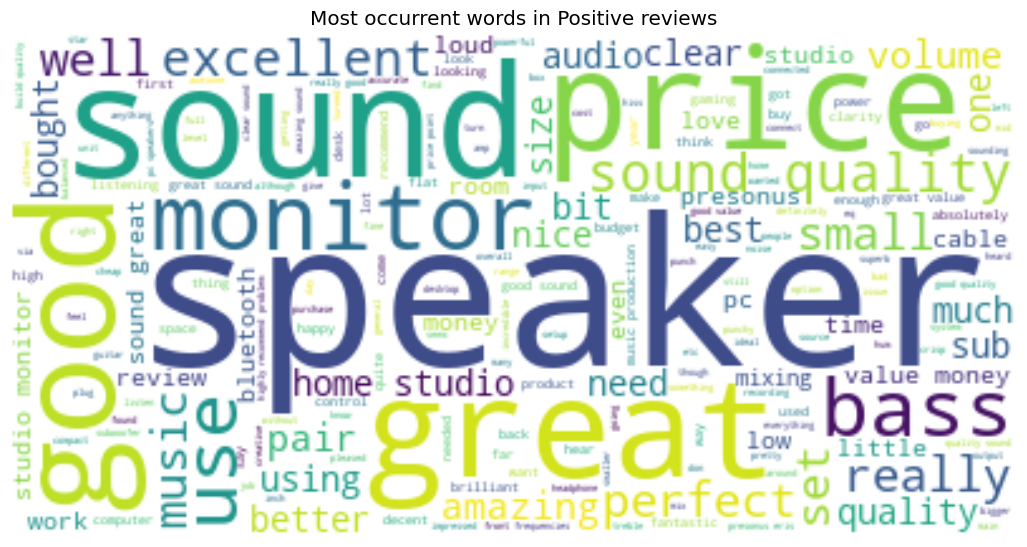

In [71]:
wordcloud = WordCloud(background_color="white", max_words=len(pos_reviews))
wordcloud.generate(pos_reviews)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most occurrent words in Positive reviews")
plt.show()

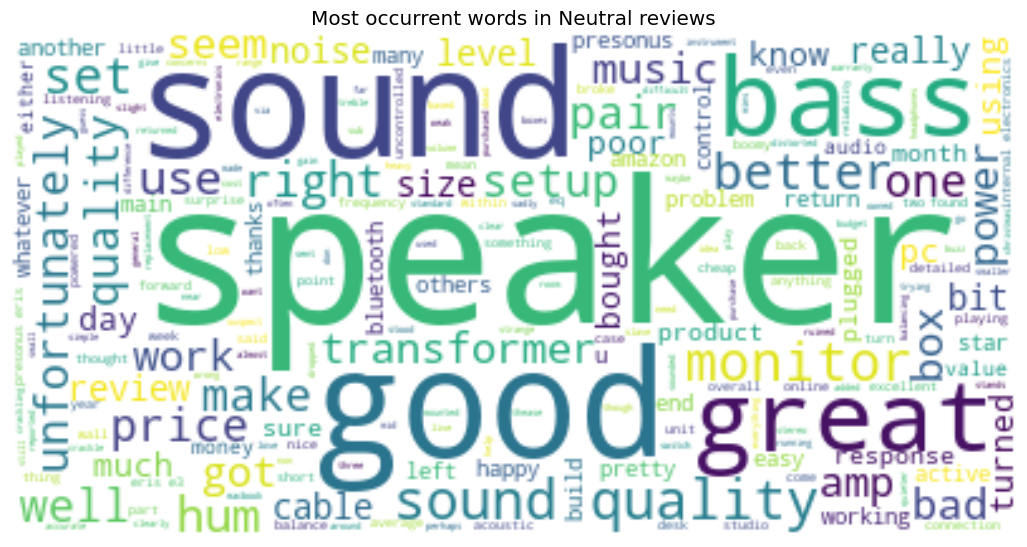

In [72]:
wordcloud = WordCloud(background_color="white", max_words=len(neu_reviews))
wordcloud.generate(neu_reviews)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most occurrent words in Neutral reviews")
plt.show()

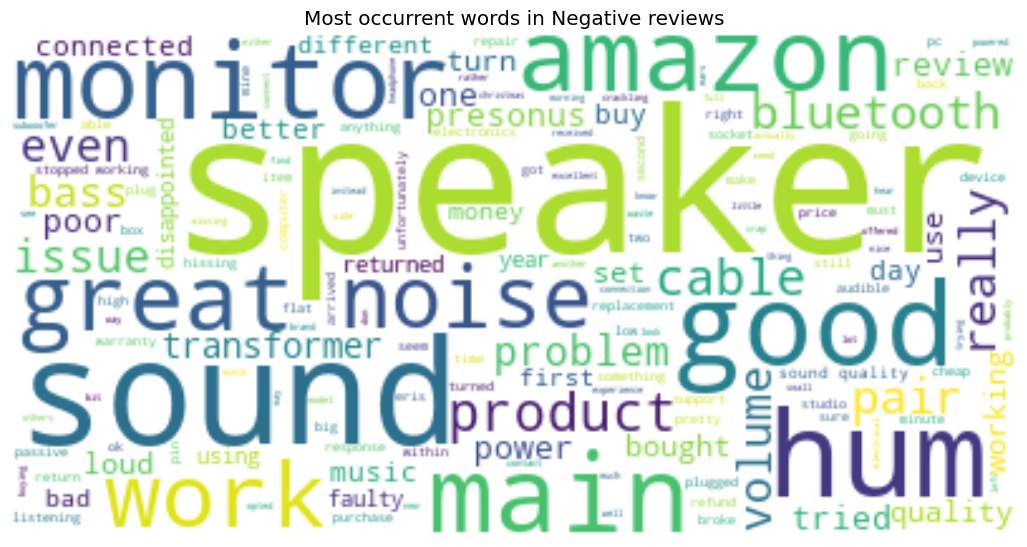

In [73]:
wordcloud = WordCloud(background_color="white", max_words=len(neg_reviews))
wordcloud.generate(neg_reviews)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most occurrent words in Negative reviews")
plt.show()

Wordclouds could be really useful to grasp some ideas of the most occurrent words, but in this case there are no important differences in the words of the 3 images.

### N-gram analysis

Going into a deeper dive into the sentiment analysis, n-grams are contiguous sequences of n words within a text. Analyzing text using n-grams in combination with sentiment analysis can provide valuable insights into the relationship between word sequences and sentiment.

In this section there will be plotted the most frequent uni-bi-trigrams in reviews based on sentiments. The following function is in fact useful to generate and plot the most occurrent n-grams of the various Corpura:
- the first part generates all the n-grams of the Clean reviews column according to the inputted sentiment given.
- the second one plots in a horizontal barplot, according to the given dimension of the n-gram, the most common 10 n-grams with their occurencies.

In [74]:
def ngram_plot(sentiment:str, n):
    tokens = nltk.word_tokenize(" ".join(df[df['Sentiment'] == sentiment.capitalize()]['Clean Review']))         # tokenizing all the strings joined together
    sentiment = sentiment.capitalize()
    
    if n == 1:
        ngram_freq = FreqDist(tokens)
        most_common_unigrams = ngram_freq.most_common(10)
        unigrams = [word for word, _ in most_common_unigrams]
        frequencies = [freq for _, freq in most_common_unigrams]

        plt.barh(unigrams, frequencies, color="blue")
        plt.xlabel('Frequency')
        plt.ylabel('Unigrams')
        plt.title(f'Most common Unigrams in {sentiment} reviews')
        plt.gca().invert_yaxis()  # Invert the y-axis to show higher frequencies at the top
        plt.show()
    
    else:
        grams = list(ngrams(tokens, n))        # using nltk's ngrams function to generate them
        ngram_freq = FreqDist(grams)
        most_common_ngrams = ngram_freq.most_common(10)
        grams = [' '.join(sentence) for sentence, _ in most_common_ngrams]
        frequencies = [freq for _, freq in most_common_ngrams]
        
        if n == 2:
            plt.barh(grams, frequencies, color = "green")
            plt.ylabel('Bigrams')
            plt.title(f'Most common Bigrams in {sentiment} reviews')
        elif n == 3:
            plt.barh(grams, frequencies, color = "purple")
            plt.ylabel('Trigrams')
            plt.title(f'Most common Trigrams in {sentiment} reviews')
        else:
            plt.barh(grams, frequencies, color = "red")
            plt.ylabel(f'{n}-grams')
            plt.title(f'Most common {n}-grams in {sentiment} reviews')
        plt.xlabel('Frequency')
        plt.gca().invert_yaxis()  # Invert the y-axis to show higher frequencies at the top
        plt.show()

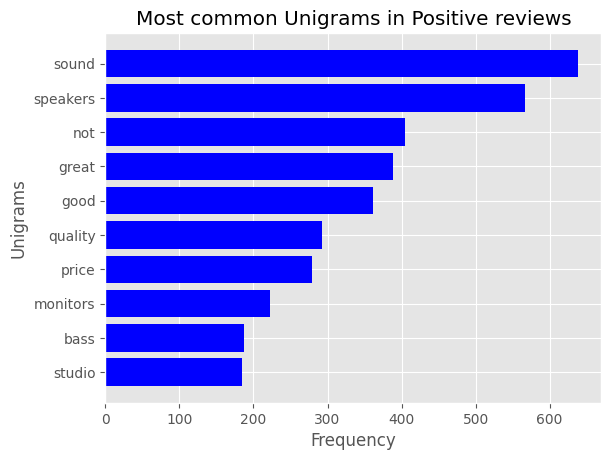

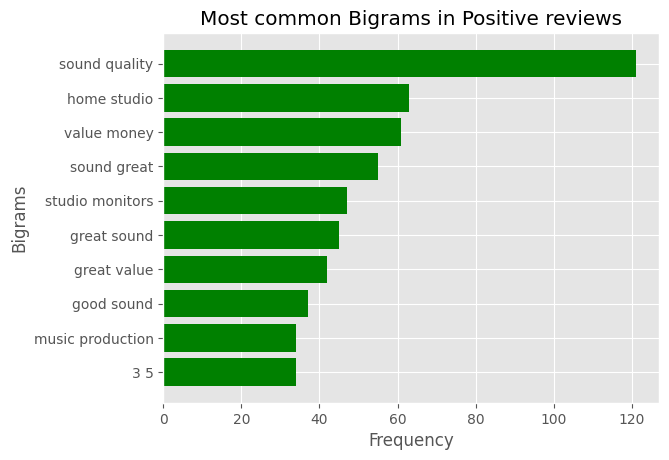

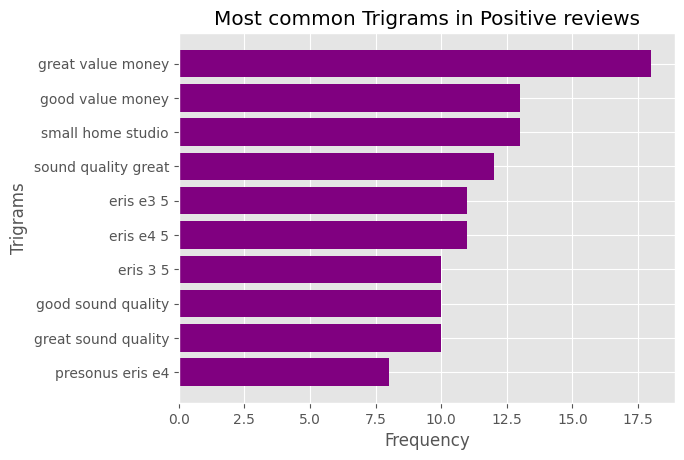

In [75]:
for i in range(1,4):
    ngram_plot('positive', i)

In [76]:
df[["Title", "Content", "Rating"]][(df['Sentiment']=="Positive")&(df['Clean Review'].str.contains("sound|sound quality|greate value money"))].head(4)

,Title,Content,Rating
0,good sound,seem decent build quality and good sound. very happy with purchase.,5
2,its a beauty,love its compact shape and sound,5
3,perfect upgrade for pc audio,"if you ruining cheap pc speakers those will blow your mind. clean sound, small frame, good value for money.",5
4,wonderful monitors,"it's been some years since using any monitors as i use dt770 250's for all my audio work and wow, i'm so pleased i added these to my studio...first the sound...the sound is quite flat which is good as you can accurately eq your sound. the bass is ""even"", meaning that it's there but it's not exaggerated. the mids are very well balanced (they sound great) and the high end is also fairly well balanced and you can get some nice air and snap when eqing. for those that have the bayer dynamic dt770 250's, you'll find your headphones have more ""air"" and snap a bit more in the highs by default, the lower mids probably have a little more punch, but not much. going back and forth between the 770's and the monitors should be a similar(ish) experience...build quality and size..very petit in size, they don't take up much room. the build is absolutely fine for the price. no issues there...you have standard connections by means of speaker wire and phono to 3.5mm (unbalanced). i'd recommend using some trs to trs to help eliminate noise from emf...on the backs you also have access to bass and treble knobs to help tune the sound to your room...on the front you have the power switch and 3.5mm ports for headphones and phone so you can play music from your phone via the correct cable, usually 3.5mm to 3.5mm. just note that the headphone in isn't powerful enough to power 250ohm headphones...overall, these monitors are brilliant and well worth the price.",5


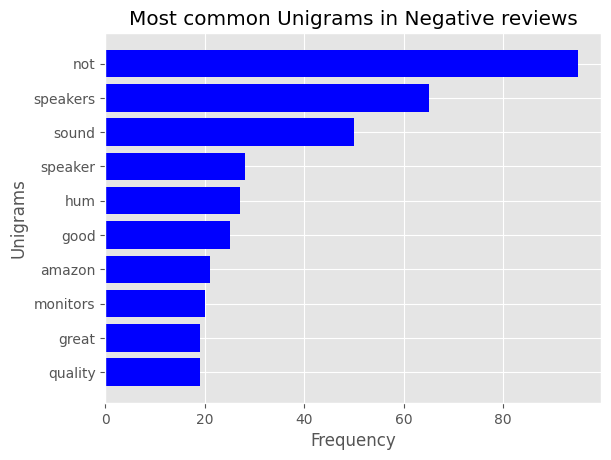

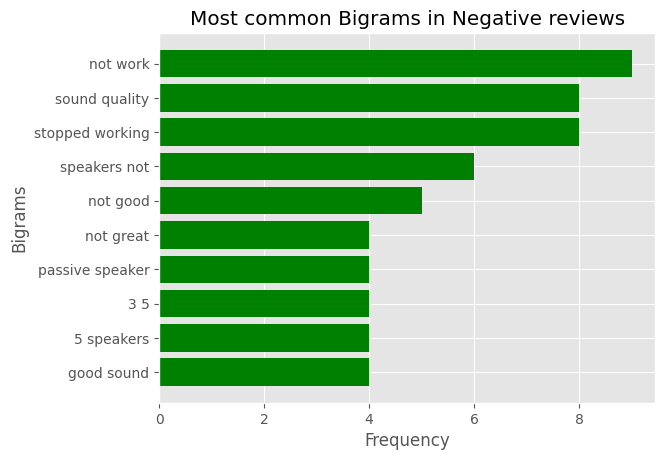

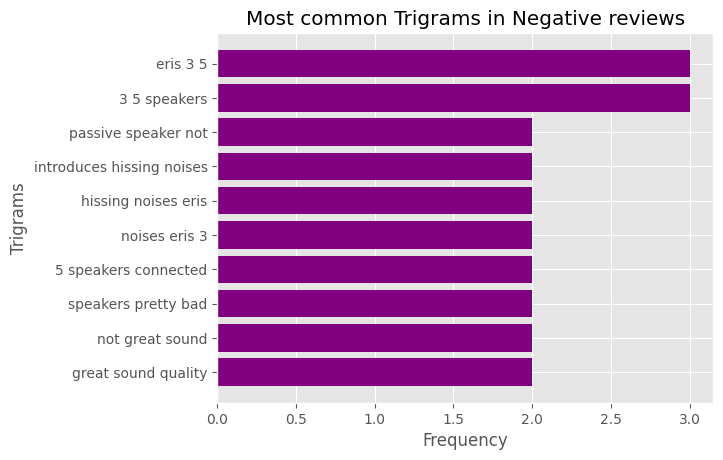

In [77]:
for i in range(1,4):
    ngram_plot('negative', i)

In [78]:
df[["Title", "Content", "Rating"]][(df['Sentiment']=="Negative")&(df['Clean Review'].str.contains("not|not work|eris 3 5"))].head(4)

,Title,Content,Rating
5,not loud enough,these are probably suited for bedroom use and not anything more. the bass kept cutting out with the highs and mids at times also doing the same. not great at all - i opted for krk’s instead!,2
6,faulty,passive speaker won't connect to the main speaker.. faulty.very disappointed,1
9,crackling sound when connected to bluetooth,"i’d like to preface this review by saying i tried 2 different sets of these speakers (both the bluetooth version), brand new, and both had the exact same issue, so must be a model issue rather than a one-off problem...the first pair i bought had a constant crackling/buzzing noise coming from the passive speaker when connected to bluetooth. the noise disappeared when disconnected from bluetooth, but appeared instantly when connected. it was audible at low volumes which ruined the listening experience so i exchanged for another set...this second set had the exact same problem. i tried connecting a different bluetooth device, i tried moving the speakers to different rooms, moving electrical devices away, swapping cables around… but the noise would not disappear no matter what i tried...really disappointing and has massively turned me away from purchasing presonus products again...i started the returns process on 2nd may 2023, posted the item the same day, and still have not had a refund - today is 12th may 2023. would love an update on my refund please?",1
20,badly manufactured!!,"glue missing on the main cone which resulted in bad vibrations and hissing, not happy with the overall build of these monitors, would not recommend to anyone",2


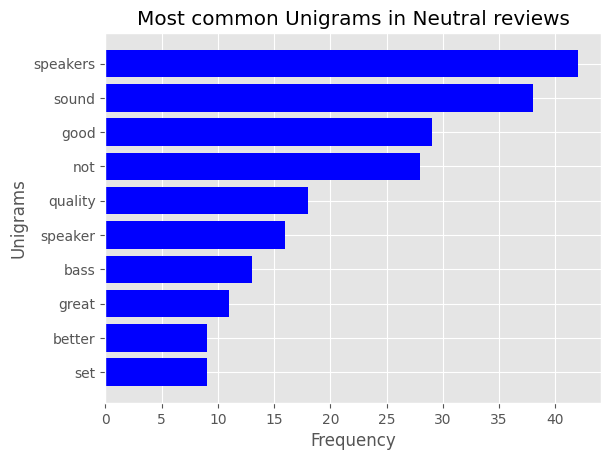

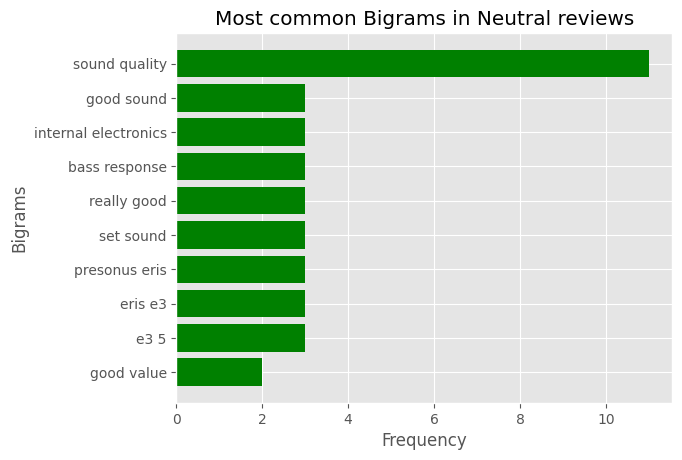

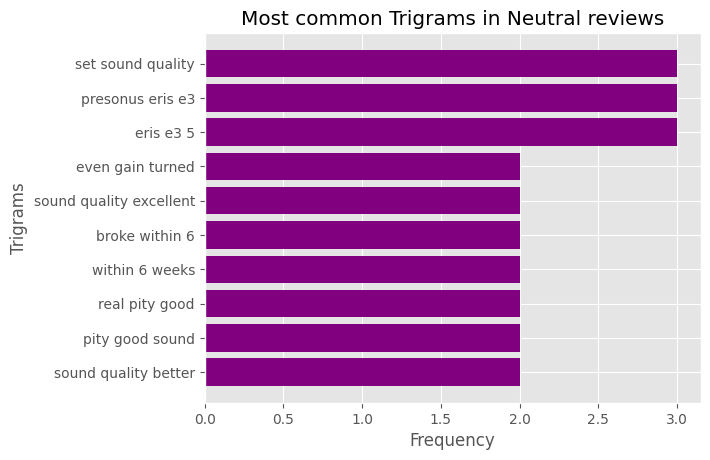

In [79]:
for i in range(1,4):
    ngram_plot('neutral', i)

In [80]:
df[["Title", "Content", "Rating"]][(df['Sentiment']=="Neutral")&(df['Clean Review'].str.contains("speakers|sound quality|set sound quality"))].head()

,Title,Content,Rating
59,yeah good value for money,"good speakers for the price..clear, accurate, clean speakers which i bought for improving my day to day audio when wfh and either on teams or listening to music...would a more ‘domestic’ speaker have been better than a speaker trying to be a budget monitor speaker, i don’t know. probably. maybe...but this is good, has bluetooth, works well and got simple controls with minimum fuss.",3
121,great on paper,"had a hum on one of the units and had to return. such a shame as, otherwise the sound quality was excellent. build quality, however, is obviously suspect.",3
212,broke within 6 weeks,"real pity. good sound but internal connections broke within 6 weeks. the speakers had not been moved since setup so i guess the internal electronics were poor. as i said, a real pity.",3
214,good sound quality but bad qc,"i am using it with my macbook pro for general usage, listening to music, video, gaming. the sound quality is better than another m brand similar price speaker. but it did not turn on after a week. have to replace another hardware.",3
216,delighted,"so much better than the audioengine for use as pc speakers and at a third of the cost. couldn’t be more happy so far..edit:.after three months use i know the product better now and have dropped two stars. my use case is for simple pc use: youtube, the odd game, non-critical music listening etc… problem is that the stereo imaging is poor. you can often clearly notice distinct and separate sound out of the left and right channels. perhaps that is how a monitor as opposed to a standard speaker is supposed to work. but it’s no good for my use case.",3


From these last plots we can now have a solid idea on, for example, the most loved or hated features of a product: in this case it looks like the customers love the high sound quality the speakers offer given their size and price. On the other side, it looks like that in negative reviews the sound quality is also sometimes criticized and it can happend that the product is damaged or faulty when it arrives the customers.

In [81]:
df.to_csv('G:/Il mio Drive/MAGISTRALE/IT Coding/Project/Sentiment-Analysis-on-Amazon-product-reviews/Data/after_EDA_revs.csv')